# GenCast

### Colab setup

Run the following cell to setup the environment in colab:

In [ ]:
# Clone repo
!git clone https://github.com/openclimatefix/graph_weather.git

# Just for colab (to install torch-scatter, sparse and cluster in a faster way)
# See: https://stackoverflow.com/questions/67285115/building-wheels-for-torch-sparse-in-colab-takes-forever
import torch  # noqa: F401

%pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
%pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
%pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
%pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
%pip install git+https://github.com/pyg-team/pytorch_geometric.git
%pip install pyshtools
# Rename folder
!mv graph_weather graph_weather_repo
%cd graph_weather_repo

# Install other dependencies (ignore pandas error)
%pip install -r requirements.txt
%pip install pytest

# Install weatherbench
%pip install git+https://github.com/google-research/weatherbench2.git

# Pip might complain about the Pandas version. The notebook should still work as expected.
import apache_beam  # noqa: F401
import weatherbench2  # noqa: F401

# Run the code below to access cloud data on Colab!
from google.colab import auth  # type: ignore

auth.authenticate_user()

### Local setup

Assuming that everything else is already installed

In [2]:
#%pip install git+https://github.com/google-research/weatherbench2.git

# Pip might complain about the Pandas version. The notebook should still work as expected.
import apache_beam  # noqa: F811, F401
import weatherbench2  # noqa: F811, F401

%cd ..

/home/gbruno16/Code/graph_weather_dev


## Dataset and Dataloader

Set configuration for our datasets

In [11]:
atmospheric_features = ["geopotential", 
                        "specific_humidity",
                        "temperature",
                        "u_component_of_wind",
                        "v_component_of_wind",
                        "vertical_velocity"]
        
single_features = ["2m_temperature", 
                        "10m_u_component_of_wind",
                        "10m_v_component_of_wind",
                        "mean_sea_level_pressure",
                        #"sea_surface_temperature",
                        "total_precipitation_12hr"]

static_features = ["geopotential_at_surface", 
                        "land_sea_mask"]

#obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
#obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-512x256_equiangular_conservative.zarr'

batch_size = 2

In [15]:
import numpy as np
import torch
from torch.utils.data import DataLoader

from graph_weather.data.gencast_dataloader import BatchedGenCastDataset, GenCastDataset

# Uncomment the following lines to use dask multiworkers and cache
""""
import dask
from dask.cache import Cache
use_dask_cache = True
use_dask_multiworkers = True

if use_dask_multiworkers:
    dask.config.set(scheduler="threads", num_workers=4)
if use_dask_cache:
    cache = Cache(1e10)  # 10gb cache
    cache.register()
"""

# Classic dataset/dataloader
dataset_1 = GenCastDataset(
    obs_path=obs_path,
    atmospheric_features=atmospheric_features,
    single_features=single_features,
    static_features=static_features,
)
data_loader_1 = DataLoader(dataset_1, batch_size=batch_size)

# Batched dataset (we don't need a dataloader, but the output is np.darray!)
dataset_2 = BatchedGenCastDataset(
    obs_path=obs_path,
    atmospheric_features=atmospheric_features,
    single_features=single_features,
    static_features=static_features,
    batch_size=batch_size,
)

print("Loading the classic dataset")
x_1, noise_levels_1, ny_1, y_1 = next(iter(data_loader_1))
print("Loading the batched dataset")
x_2, noise_levels_2, ny_2, y_2 = dataset_2[0]
print("Checking that samples are exactly the same")
assert torch.allclose(x_1, torch.tensor(x_2))
assert torch.allclose(y_1, torch.tensor(y_2))
print("They are the same!")

Loading the classic dataset
Loading the batched dataset
Checking that samples are exactly the same
They are the same!


Plots

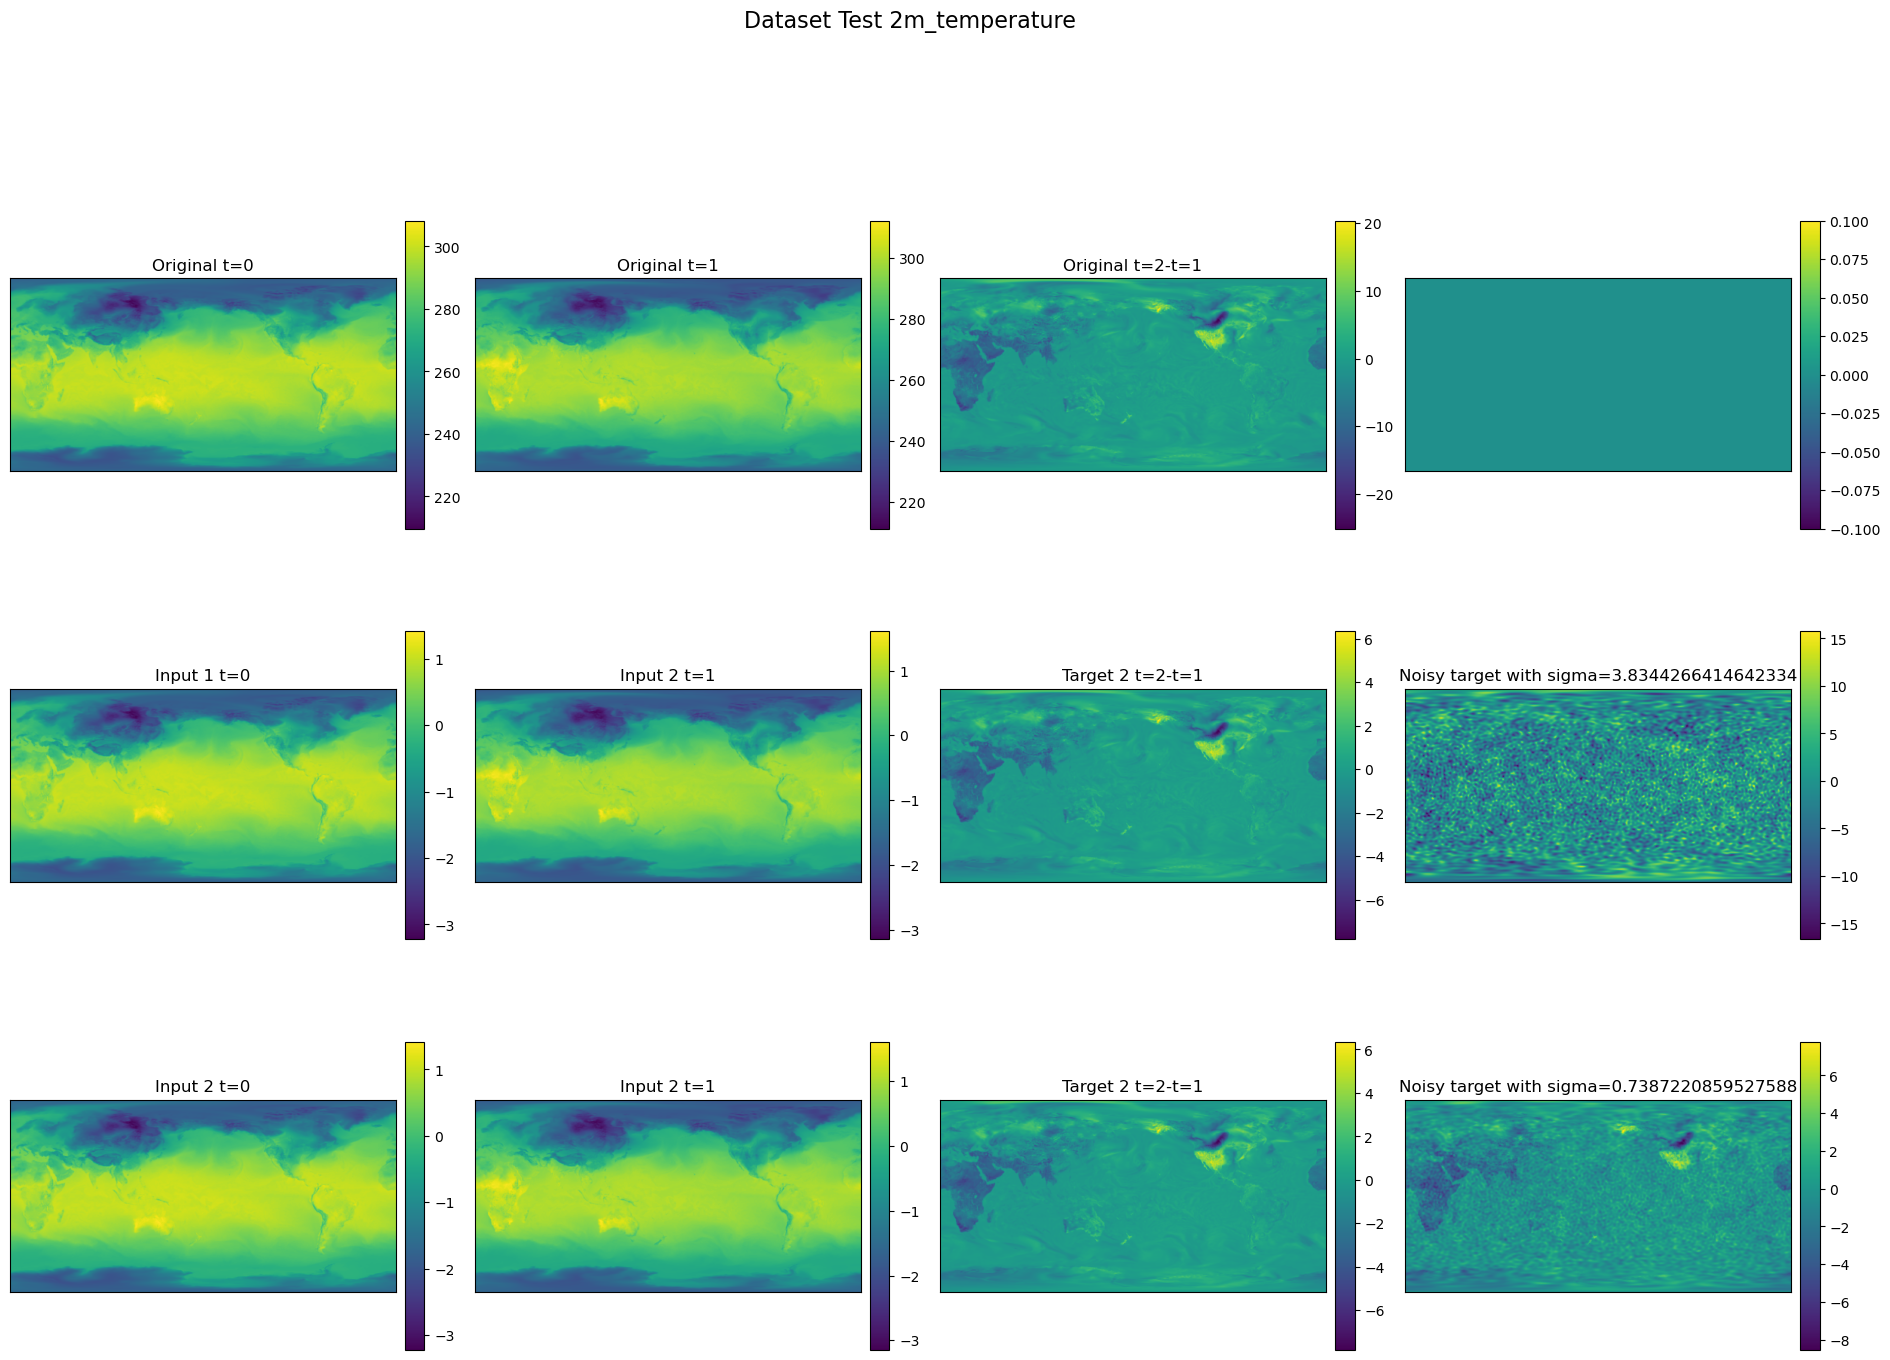

In [16]:
# Plots
import matplotlib.pyplot as plt
import xarray as xr

data = xr.open_zarr(obs_path, chunks={})

figure = plt.figure(figsize=(4 * 2 * 3, 4 * 4))
figure.suptitle("Dataset Test 2m_temperature", fontsize=16)
figure.subplots_adjust(wspace=0, hspace=0)
figure.tight_layout()

plot_data = [
    {"title": "Original t=0", "data": data.isel(time=0)["2m_temperature"].values},
    {"title": "Original t=1", "data": data.isel(time=2)["2m_temperature"].values},
    {
        "title": "Original t=2-t=1",
        "data": data.isel(time=4)["2m_temperature"].values
        - data.isel(time=2)["2m_temperature"].values,
    },
    {"title": "", "data": np.zeros_like(x_1[0][:,:,78])},
    {"title": "Input 1 t=0", "data": x_1[0][:, :, 78]},
    {"title": "Input 2 t=1", "data": x_1[0][:, :, 89 + 78]},
    {"title": "Target 2 t=2-t=1", "data": y_1[0][:, :, 78]},
    {
        "title": "Noisy target with sigma=" + str(noise_levels_1[0].item()),
        "data": ny_1[0][:, :, 78],
    },
    {"title": "Input 2 t=0", "data": x_2[0][:, :, 78]},
    {"title": "Input 2 t=1", "data": x_2[0][:, :, 89 + 78]},
    {"title": "Target 2 t=2-t=1", "data": y_2[0][:, :, 78]},
    {
        "title": "Noisy target with sigma=" + str(noise_levels_2[0].item()),
        "data": ny_2[0][:, :, 78],
    },
]

for i in range(12):
    ax = figure.add_subplot(3, 4, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(plot_data[i]["title"])
    im = ax.imshow(plot_data[i]["data"].T, origin="lower")
    plt.colorbar(mappable=im, ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.75)

## Building the graph

Let's explore a small graph

In [ ]:
import numpy as np

from graph_weather.models.gencast import GraphBuilder

grid_lat = np.arange(-90, 90, 1)
grid_lon = np.arange(0, 360, 1)

graphs = GraphBuilder(grid_lat=grid_lat, grid_lon=grid_lon, splits=0, num_hops=1)

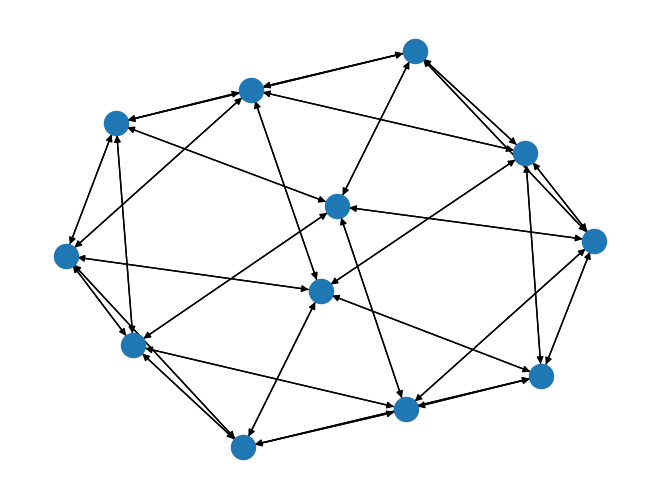

In [4]:
# Mesh
import networkx as nx
from torch_geometric.utils import to_networkx

g = to_networkx(graphs.mesh_graph)
nx.draw(g)


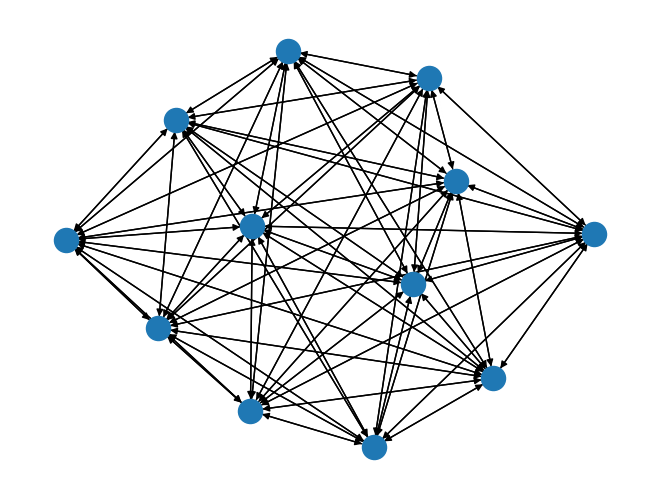

In [8]:
# khop mesh
import networkx as nx
from torch_geometric.utils import to_networkx

g = to_networkx(graphs.khop_mesh_graph)
nx.draw(g)


Some 3d plots (if matplotlib widget it's available)

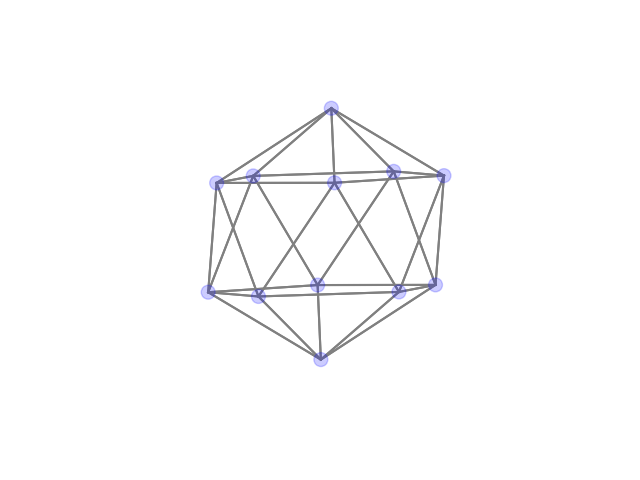

In [9]:
# Mesh
%matplotlib widget
import matplotlib.pyplot as plt

from graph_weather.models.gencast.graph.model_utils import (
    lat_lon_deg_to_spherical,
    spherical_to_cartesian,
)

g = graphs.mesh_graph

node_lat = graphs._mesh_nodes_lat
node_lon = graphs._mesh_nodes_lon
node_phi, node_theta = lat_lon_deg_to_spherical(node_lat, node_lon)
nodes = np.stack(spherical_to_cartesian(node_phi, node_theta), axis=-1)
edges = np.array([(nodes[u], nodes[v]) for u, v in g.edge_index.T])

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*nodes.T, alpha=0.2, s=100, color="blue")
for vizedge in edges:
    ax.plot(*vizedge.T, color="gray")
ax.grid(False)
ax.set_axis_off()

ax.set_proj_type('ortho') 
plt.tight_layout()

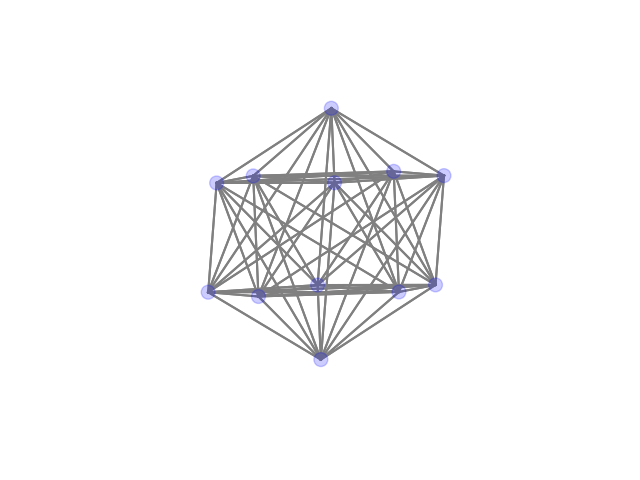

In [10]:
# khop mesh
%matplotlib widget
import matplotlib.pyplot as plt

g = graphs.khop_mesh_graph

node_lat = graphs._mesh_nodes_lat
node_lon = graphs._mesh_nodes_lon
node_phi, node_theta = lat_lon_deg_to_spherical(node_lat, node_lon)
nodes = np.stack(spherical_to_cartesian(node_phi, node_theta), axis=-1)
edges = np.array([(nodes[u], nodes[v]) for u, v in g.edge_index.T])

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*nodes.T, alpha=0.2, s=100, color="blue")
for vizedge in edges:
    ax.plot(*vizedge.T, color="gray")
ax.grid(False)
ax.set_axis_off()

ax.set_proj_type('ortho') 
plt.tight_layout()

## Denoiser

Set the dataset

In [21]:
from torch.utils.data import DataLoader

from graph_weather.data.gencast_dataloader import GenCastDataset

atmospheric_features = [
    "geopotential",
    "specific_humidity",
    "temperature",
    "u_component_of_wind",
    "v_component_of_wind",
    "vertical_velocity",
]
single_features = [
    "2m_temperature",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "mean_sea_level_pressure",
    # "sea_surface_temperature",
    "total_precipitation_12hr",
]
static_features = [
    "geopotential_at_surface",
    "land_sea_mask",
]

obs_path = "gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr"
# obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
# obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-512x256_equiangular_conservative.zarr'

dataset = GenCastDataset(
    obs_path=obs_path,
    atmospheric_features=atmospheric_features,
    single_features=single_features,
    static_features=static_features,
    max_year=2018,
    time_step=2,
)

batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size)

Predict

In [22]:
import torch

from graph_weather.models.gencast import Denoiser, WeightedMSELoss

denoiser = Denoiser(
    grid_lon=dataset.grid_lon,
    grid_lat=dataset.grid_lat,
    input_features_dim=dataset.input_features_dim,
    output_features_dim=dataset.output_features_dim,
    hidden_dims=[16, 16],
    num_blocks=3,
    num_heads=4,
    splits=0,
    num_hops=1,
    device=torch.device("cpu"),
)

criterion = WeightedMSELoss(
    grid_lat=torch.tensor(dataset.grid_lat),
    pressure_levels=torch.tensor(dataset.pressure_levels),
    num_atmospheric_features=len(dataset.atmospheric_features),
    single_features_weights=torch.tensor([1.0, 0.1, 0.1, 0.1, 0.1]),
)

optimizer = torch.optim.AdamW(denoiser.parameters(), lr=1e-3)

for i, data in enumerate(dataloader):
    corrupted_targets, prev_inputs, noise_levels, target_residuals = data
    denoiser.zero_grad()
    preds = denoiser(
        corrupted_targets=corrupted_targets, prev_inputs=prev_inputs, noise_levels=noise_levels
    )
    loss = criterion(preds, noise_levels, target_residuals)
    loss.backward()

    optimizer.step()
    print(f"Iteration {i} with  training loss {float(loss)}.")
    if i==5:
        break
    

/home/gbruno16/.conda/envs/graph/lib/python3.11/site-packages/torch_geometric/edge_index.py:784: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403238793/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


Iteration 0 with  training loss 0.09914162755012512.


KeyboardInterrupt: 

In [1]:
%cd ../

/home/gbruno16/Code/graph_weather_dev


In [19]:
import torch

from graph_weather.models.gencast.layers.modules import FourierEmbedding
batch_size = 10
output_dim = 20
fourier_embedder = FourierEmbedding(output_dim=output_dim, num_frequencies=32, base_period=16)
t = torch.rand((batch_size,1))
assert fourier_embedder(t).shape ==(batch_size, output_dim)
#print(fourier_embedder(t))
print(fourier_embedder.fourier_features(t))



tensor([[0.9537, 0.9610, 0.9672, 0.9724, 0.9767, 0.9804, 0.9835, 0.9862, 0.9883,
         0.9902, 0.9918, 0.9931, 0.9942, 0.9951, 0.9959, 0.9965, 0.9971, 0.9975,
         0.9979, 0.9983, 0.9985, 0.9988, 0.9990, 0.9991, 0.9993, 0.9994, 0.9995,
         0.9996, 0.9996, 0.9997, 0.9997, 0.9998, 0.3009, 0.2766, 0.2542, 0.2335,
         0.2144, 0.1969, 0.1807, 0.1659, 0.1522, 0.1397, 0.1281, 0.1175, 0.1078,
         0.0989, 0.0907, 0.0832, 0.0763, 0.0700, 0.0642, 0.0589, 0.0540, 0.0495,
         0.0454, 0.0416, 0.0382, 0.0350, 0.0321, 0.0295, 0.0270, 0.0248, 0.0227,
         0.0208],
        [0.6491, 0.7020, 0.7473, 0.7860, 0.8190, 0.8470, 0.8708, 0.8910, 0.9081,
         0.9225, 0.9347, 0.9450, 0.9537, 0.9610, 0.9672, 0.9724, 0.9767, 0.9804,
         0.9835, 0.9861, 0.9883, 0.9902, 0.9918, 0.9931, 0.9942, 0.9951, 0.9959,
         0.9965, 0.9971, 0.9975, 0.9979, 0.9983, 0.7607, 0.7122, 0.6645, 0.6183,
         0.5738, 0.5316, 0.4916, 0.4540, 0.4189, 0.3860, 0.3555, 0.3271, 0.3009,
         0